In [1]:
!pip install -q -U watermark

In [2]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 7.26.0

numpy       : 1.19.5
pandas      : 1.3.2
torch       : 1.11.0+cpu
transformers: 4.20.1



In [3]:
import transformers
from transformers import AutoModel, AutoTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
df_2 = pd.read_csv("comments_training_dataset - Sheet1.csv", index_col="1000")
df = df_2.dropna()
df = df.T
df.pop(450)
df = df.T
df

,comment,Prequalified sentiment,Information,Opinion,Advice,Impression,Progress,Exercise,Body,Video,Length,Reviewer
1000,,,,,,,,,,,,
0,Hello and can I ask you if I can do also other...,-0.894868,0.0,0.0,0.7,0.0,0.0,0.4,0.0,0.0,74,J
1,As a person with Lyme Disease who is chronical...,-0.992691,0.5,0.3,0.9,0.0,0.0,0.4,0.0,0.6,273,J
3,Has anyone lost weight from this? ❤️,-0.997208,0.0,0.0,0.5,0.6,0.0,0.0,0.8,0.0,36,J
4,doing this to start my fourth year of university,0.991657,0.5,0.0,0.0,0.0,0.8,0.0,0.0,0.0,48,J
5,Simply love it thought I was in shape until this,0.999816,0.2,0.8,0.0,0.4,0.2,0.0,0.5,0.0,48,J
...,...,...,...,...,...,...,...,...,...,...,...,...
2515,Mil gracias yoga with ADRIANE!!!,0.730353,0.0,0.8,0.0,0.8,0.0,0.0,0.7,0.6,32,D*
2516,So grateful for you and for this daily practic...,0.99983,0.0,0.8,0.0,0.8,0.0,0.0,0.7,0.6,69,D*
2517,Thank you ☺️\n\nMy partner and I do it every e...,0.99747,0.6,0.0,0.0,0.7,0.8,0.0,0.7,0.5,245,D*


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1613 entries, 0 to 2519
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   comment                 1613 non-null   object
 1   Prequalified sentiment  1613 non-null   object
 2   Information             1613 non-null   object
 3   Opinion                 1613 non-null   object
 4   Advice                  1613 non-null   object
 5   Impression              1613 non-null   object
 6   Progress                1613 non-null   object
 7   Exercise                1613 non-null   object
 8   Body                    1613 non-null   object
 9   Video                   1613 non-null   object
 10  Length                  1613 non-null   object
 11  Reviewer                1613 non-null   object
dtypes: object(12)
memory usage: 163.8+ KB


In [6]:
PRE_TRAINED_MODEL_NAME = "dsantistevan/bert-base-cased-bert-yoga-finetuned"

In [7]:
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [8]:
token_lens = []

for txt in df.comment:
    tokens = tokenizer.encode(txt)
    token_lens.append(len(tokens))

c:\python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


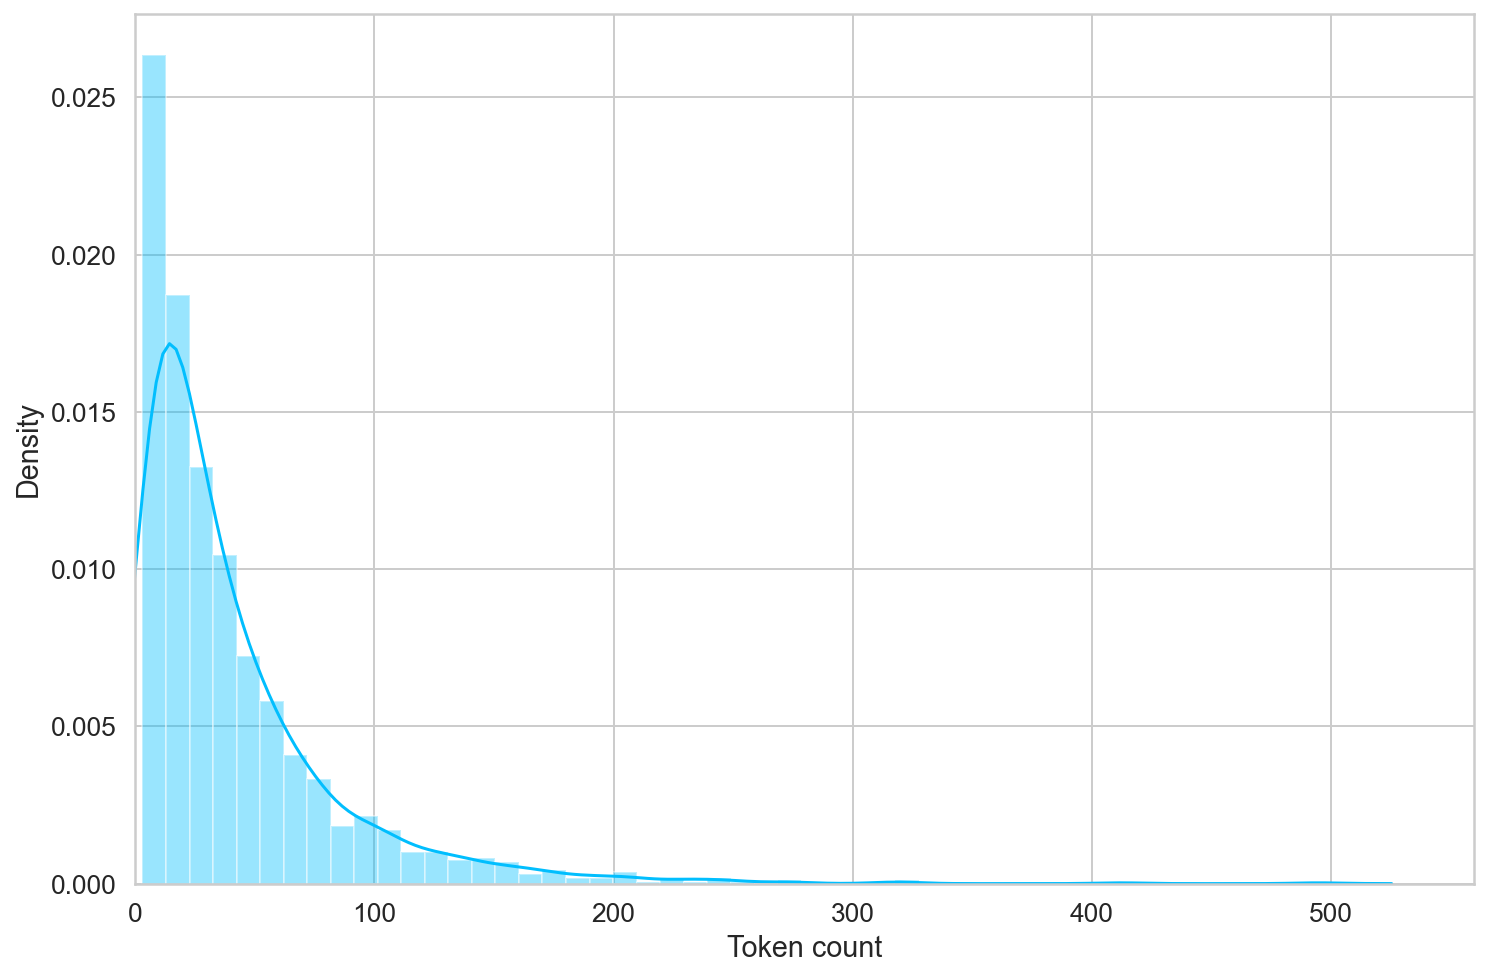

In [9]:
sns.distplot(token_lens)
plt.xlim([0, 560]);
plt.xlabel('Token count');

In [10]:
MAX_LEN = 500

In [11]:
class YTCommentDataset(Dataset):

    def __init__(self, comments, targets, tokenizer, max_len):
        self.comments = comments
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, item):
        comment = str(self.comments[item])
        target = self.targets[item:item+1]

        encoding = self.tokenizer.encode_plus(
          comment,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',
        )
        
        return {
          'comment_text': comment,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.FloatTensor(list(target))
        }

In [12]:
df_train, df_test = train_test_split(df, test_size=0.2)
df_val, df_test = train_test_split(df_test, test_size=0.5)

In [13]:
df_train.shape, df_val.shape, df_test.shape

((1290, 12), (161, 12), (162, 12))

In [14]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = YTCommentDataset(
        comments=df.comment.to_numpy(),
        targets=df.Opinion.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size
    )

In [15]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [16]:

data = next(iter(train_data_loader))
data.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\python39\lib\site-packages\transformers\tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['comment_text', 'input_ids', 'attention_mask', 'targets'])

In [17]:
print(data['targets'])

tensor([[0.7000],
        [0.0000],
        [0.8000],
        [0.5000],
        [0.8000],
        [0.7000],
        [0.0000],
        [0.3000],
        [0.8000],
        [0.6000],
        [0.0000],
        [0.6000],
        [0.6000],
        [0.5000],
        [0.2000],
        [0.7000]])


In [18]:
class SentimentScorer(nn.Module):

    def __init__(self):
        super(SentimentScorer, self).__init__()
        self.bert = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        for param in self.bert.parameters():
            param.requires_grad = False
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )[1]
        output = self.drop(pooled_output)
        return self.out(output)

In [19]:
model = SentimentScorer()
model = model.to(device)

Some weights of the model checkpoint at dsantistevan/bert-base-cased-bert-yoga-finetuned were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at dsantistevan/bert-base-cased-bert-yoga-finetuned and are newly initialized: 

In [20]:
bert_params = set()
for param in model.bert.parameters():
    param.requires_grad = False
    bert_params.add(param)

In [21]:

for param in model.parameters():
    if param not in bert_params:
        print(param)

Parameter containing:
tensor([[-8.9955e-03,  1.0302e-02,  1.1558e-02,  2.2886e-02, -1.4123e-02,
          2.6413e-02,  2.1788e-02,  3.4780e-02,  8.4839e-03, -2.4000e-02,
          2.9890e-02, -3.2827e-02,  4.5486e-03,  8.7773e-03,  4.8264e-03,
          2.2931e-03, -1.0624e-02, -2.4483e-02,  1.0868e-02, -3.1929e-03,
          8.1765e-03,  3.1240e-02, -9.6459e-03,  3.4003e-02, -2.7085e-02,
         -1.8845e-02,  8.7198e-03, -1.6218e-02, -1.6375e-02,  2.2257e-02,
         -1.9899e-02,  2.9875e-02,  2.9006e-02, -2.7636e-02, -3.0620e-02,
          6.2384e-03,  2.4154e-02, -2.9063e-02,  2.7422e-02, -2.5325e-03,
         -2.3274e-02, -1.2020e-02,  2.7578e-03, -1.5582e-03,  9.0998e-04,
         -6.1661e-03, -3.5039e-02,  6.0533e-03,  1.2634e-02,  2.9165e-03,
         -1.1201e-02,  1.5335e-02,  4.2582e-03,  4.3833e-03, -2.3553e-02,
          2.5123e-03, -4.2241e-03, -7.3261e-03, -3.6536e-04,  2.8893e-02,
          7.4584e-05,  1.1374e-02,  1.3125e-02, -5.1762e-03,  2.2858e-02,
         -2.6297

In [22]:
for i in model.out.parameters():
    print(i.shape)

torch.Size([1, 768])
torch.Size([1])


In [23]:
EPOCHS = 20

optimizer = torch.optim.SGD(model.out.parameters(), lr=0.002)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.MSELoss().to(device)

In [24]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
    model = model.train()

    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [25]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [26]:
%%time

history = defaultdict(list)
best_accuracy = 0
best_loss = float('inf')

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,    
        loss_fn, 
        optimizer, 
        device, 
        scheduler, 
        len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn, 
        device, 
        len(df_val)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_loss < best_loss:
        torch.save(model.state_dict(), 'best_model_state_opinion.bin')
        best_loss = val_loss

Epoch 1/20
----------
Train loss 0.15677634028740872 accuracy 3.66046511627907
Val   loss 0.09565027024258267 accuracy 3.8819875776397517

Epoch 2/20
----------
Train loss 0.1272106800734261 accuracy 3.66046511627907
Val   loss 0.09371052276004445 accuracy 3.8819875776397517

Epoch 3/20
----------
Train loss 0.12436604481420399 accuracy 3.66046511627907
Val   loss 0.09270040589300069 accuracy 3.8819875776397517

Epoch 4/20
----------
Train loss 0.11957440695460932 accuracy 3.66046511627907
Val   loss 0.09197684716094624 accuracy 3.8819875776397517

Epoch 5/20
----------
Train loss 0.11848034907454326 accuracy 3.66046511627907
Val   loss 0.09107653898271648 accuracy 3.8819875776397517

Epoch 6/20
----------
Train loss 0.11568454919773856 accuracy 3.66046511627907
Val   loss 0.09037306125868451 accuracy 3.8819875776397517

Epoch 7/20
----------
Train loss 0.11705955012161055 accuracy 3.66046511627907
Val   loss 0.08974489738995378 accuracy 3.8819875776397517

Epoch 8/20
----------
Train 

In [27]:
sumaa=0
for i in train_data_loader:
    for j in range(len(i['input_ids'])-1):
        print(model(input_ids=i['input_ids'][j:j+1],attention_mask=i['attention_mask'][j:j+1]))
        print(i['targets'][j])
        

tensor([[0.4439]], grad_fn=<AddmmBackward0>)
tensor([0.7000])
tensor([[0.4312]], grad_fn=<AddmmBackward0>)
tensor([0.])
tensor([[0.5063]], grad_fn=<AddmmBackward0>)
tensor([0.8000])
tensor([[0.4864]], grad_fn=<AddmmBackward0>)
tensor([0.5000])
tensor([[0.4404]], grad_fn=<AddmmBackward0>)
tensor([0.8000])
tensor([[0.4277]], grad_fn=<AddmmBackward0>)
tensor([0.7000])
tensor([[0.3604]], grad_fn=<AddmmBackward0>)
tensor([0.])
tensor([[0.4201]], grad_fn=<AddmmBackward0>)
tensor([0.3000])
tensor([[0.4092]], grad_fn=<AddmmBackward0>)
tensor([0.8000])
tensor([[0.3378]], grad_fn=<AddmmBackward0>)
tensor([0.6000])
tensor([[0.3527]], grad_fn=<AddmmBackward0>)
tensor([0.])
tensor([[0.2990]], grad_fn=<AddmmBackward0>)
tensor([0.6000])
tensor([[0.2773]], grad_fn=<AddmmBackward0>)
tensor([0.6000])
tensor([[0.4864]], grad_fn=<AddmmBackward0>)
tensor([0.5000])
tensor([[0.4113]], grad_fn=<AddmmBackward0>)
tensor([0.2000])
tensor([[0.4314]], grad_fn=<AddmmBackward0>)
tensor([0.4000])
tensor([[0.3579]], g

tensor([[0.4361]], grad_fn=<AddmmBackward0>)
tensor([0.5000])
tensor([[0.1012]], grad_fn=<AddmmBackward0>)
tensor([-0.5000])
tensor([[0.3860]], grad_fn=<AddmmBackward0>)
tensor([0.4000])
tensor([[0.3558]], grad_fn=<AddmmBackward0>)
tensor([0.4000])
tensor([[0.4228]], grad_fn=<AddmmBackward0>)
tensor([0.6000])
tensor([[0.3421]], grad_fn=<AddmmBackward0>)
tensor([0.5000])
tensor([[0.5191]], grad_fn=<AddmmBackward0>)
tensor([0.7000])
tensor([[0.3724]], grad_fn=<AddmmBackward0>)
tensor([0.4000])
tensor([[0.2929]], grad_fn=<AddmmBackward0>)
tensor([0.7000])
tensor([[0.3319]], grad_fn=<AddmmBackward0>)
tensor([0.7000])
tensor([[0.4345]], grad_fn=<AddmmBackward0>)
tensor([0.6000])
tensor([[0.3087]], grad_fn=<AddmmBackward0>)
tensor([0.6000])
tensor([[0.3379]], grad_fn=<AddmmBackward0>)
tensor([0.4000])
tensor([[0.4864]], grad_fn=<AddmmBackward0>)
tensor([0.5000])
tensor([[0.4043]], grad_fn=<AddmmBackward0>)
tensor([0.])
tensor([[0.2602]], grad_fn=<AddmmBackward0>)
tensor([-0.3000])
tensor([[0

tensor([[0.3722]], grad_fn=<AddmmBackward0>)
tensor([0.9000])
tensor([[0.1874]], grad_fn=<AddmmBackward0>)
tensor([-0.9000])
tensor([[0.3621]], grad_fn=<AddmmBackward0>)
tensor([0.6000])
tensor([[0.4068]], grad_fn=<AddmmBackward0>)
tensor([0.5000])
tensor([[0.2404]], grad_fn=<AddmmBackward0>)
tensor([0.2000])
tensor([[0.3918]], grad_fn=<AddmmBackward0>)
tensor([0.7000])
tensor([[0.2986]], grad_fn=<AddmmBackward0>)
tensor([0.])
tensor([[0.2974]], grad_fn=<AddmmBackward0>)
tensor([0.4000])
tensor([[0.3237]], grad_fn=<AddmmBackward0>)
tensor([-0.5000])
tensor([[0.2885]], grad_fn=<AddmmBackward0>)
tensor([0.])
tensor([[0.2341]], grad_fn=<AddmmBackward0>)
tensor([-0.9000])
tensor([[0.4148]], grad_fn=<AddmmBackward0>)
tensor([0.8000])
tensor([[0.3514]], grad_fn=<AddmmBackward0>)
tensor([0.8000])
tensor([[0.3124]], grad_fn=<AddmmBackward0>)
tensor([-0.4000])
tensor([[0.4243]], grad_fn=<AddmmBackward0>)
tensor([0.7000])
tensor([[0.4122]], grad_fn=<AddmmBackward0>)
tensor([0.7000])
tensor([[0.0

tensor([[0.4970]], grad_fn=<AddmmBackward0>)
tensor([0.8000])
tensor([[0.4215]], grad_fn=<AddmmBackward0>)
tensor([0.7000])
tensor([[0.3459]], grad_fn=<AddmmBackward0>)
tensor([0.7000])
tensor([[0.3424]], grad_fn=<AddmmBackward0>)
tensor([0.6000])
tensor([[0.4586]], grad_fn=<AddmmBackward0>)
tensor([0.7000])
tensor([[0.4308]], grad_fn=<AddmmBackward0>)
tensor([0.4000])
tensor([[0.4252]], grad_fn=<AddmmBackward0>)
tensor([0.4000])
tensor([[0.0838]], grad_fn=<AddmmBackward0>)
tensor([0.])
tensor([[0.4321]], grad_fn=<AddmmBackward0>)
tensor([0.6000])
tensor([[0.3840]], grad_fn=<AddmmBackward0>)
tensor([0.])
tensor([[0.4094]], grad_fn=<AddmmBackward0>)
tensor([0.7000])
tensor([[0.3594]], grad_fn=<AddmmBackward0>)
tensor([0.9000])
tensor([[0.3603]], grad_fn=<AddmmBackward0>)
tensor([0.7000])
tensor([[0.1937]], grad_fn=<AddmmBackward0>)
tensor([-0.6000])
tensor([[0.3684]], grad_fn=<AddmmBackward0>)
tensor([0.8000])
tensor([[0.4728]], grad_fn=<AddmmBackward0>)
tensor([0.7000])
tensor([[0.4464

tensor([[0.2983]], grad_fn=<AddmmBackward0>)
tensor([-0.4000])
tensor([[0.4342]], grad_fn=<AddmmBackward0>)
tensor([0.2000])
tensor([[0.2246]], grad_fn=<AddmmBackward0>)
tensor([0.8000])
tensor([[0.5037]], grad_fn=<AddmmBackward0>)
tensor([0.5000])
tensor([[0.2025]], grad_fn=<AddmmBackward0>)
tensor([0.8000])
tensor([[0.5173]], grad_fn=<AddmmBackward0>)
tensor([0.8000])
tensor([[0.3400]], grad_fn=<AddmmBackward0>)
tensor([0.2000])
tensor([[0.3748]], grad_fn=<AddmmBackward0>)
tensor([0.])
tensor([[0.3773]], grad_fn=<AddmmBackward0>)
tensor([0.7000])
tensor([[0.1795]], grad_fn=<AddmmBackward0>)
tensor([0.2000])
tensor([[0.4388]], grad_fn=<AddmmBackward0>)
tensor([0.3000])
tensor([[0.4180]], grad_fn=<AddmmBackward0>)
tensor([0.6000])
tensor([[0.3306]], grad_fn=<AddmmBackward0>)
tensor([0.7000])
tensor([[0.4833]], grad_fn=<AddmmBackward0>)
tensor([0.7000])
tensor([[0.3265]], grad_fn=<AddmmBackward0>)
tensor([0.])
tensor([[0.3989]], grad_fn=<AddmmBackward0>)
tensor([0.6000])
tensor([[0.3858

tensor([[0.3702]], grad_fn=<AddmmBackward0>)
tensor([0.4000])
tensor([[0.2116]], grad_fn=<AddmmBackward0>)
tensor([0.5000])
tensor([[0.4505]], grad_fn=<AddmmBackward0>)
tensor([0.7000])
tensor([[0.4078]], grad_fn=<AddmmBackward0>)
tensor([0.])
tensor([[0.3526]], grad_fn=<AddmmBackward0>)
tensor([0.5000])
tensor([[0.3402]], grad_fn=<AddmmBackward0>)
tensor([0.4000])
tensor([[0.0905]], grad_fn=<AddmmBackward0>)
tensor([-0.2000])
tensor([[0.3556]], grad_fn=<AddmmBackward0>)
tensor([0.])
tensor([[0.4353]], grad_fn=<AddmmBackward0>)
tensor([0.6000])
tensor([[0.3355]], grad_fn=<AddmmBackward0>)
tensor([0.3000])
tensor([[0.3004]], grad_fn=<AddmmBackward0>)
tensor([-0.7000])
tensor([[0.3345]], grad_fn=<AddmmBackward0>)
tensor([0.])
tensor([[0.3914]], grad_fn=<AddmmBackward0>)
tensor([0.6000])
tensor([[0.3944]], grad_fn=<AddmmBackward0>)
tensor([0.])
tensor([[0.3452]], grad_fn=<AddmmBackward0>)
tensor([0.])
tensor([[0.4343]], grad_fn=<AddmmBackward0>)
tensor([0.7000])
tensor([[0.3666]], grad_fn

tensor([[0.4218]], grad_fn=<AddmmBackward0>)
tensor([0.])
tensor([[0.1874]], grad_fn=<AddmmBackward0>)
tensor([0.])
tensor([[0.4587]], grad_fn=<AddmmBackward0>)
tensor([0.5000])
tensor([[0.5463]], grad_fn=<AddmmBackward0>)
tensor([0.7000])
tensor([[0.4333]], grad_fn=<AddmmBackward0>)
tensor([0.])
tensor([[0.4864]], grad_fn=<AddmmBackward0>)
tensor([0.5000])
tensor([[0.5055]], grad_fn=<AddmmBackward0>)
tensor([0.7000])
tensor([[0.3360]], grad_fn=<AddmmBackward0>)
tensor([-0.3000])
tensor([[0.4196]], grad_fn=<AddmmBackward0>)
tensor([0.7000])
tensor([[0.3117]], grad_fn=<AddmmBackward0>)
tensor([0.])
tensor([[0.4864]], grad_fn=<AddmmBackward0>)
tensor([0.5000])
tensor([[0.3712]], grad_fn=<AddmmBackward0>)
tensor([0.6000])
tensor([[0.1201]], grad_fn=<AddmmBackward0>)
tensor([0.])
tensor([[0.4324]], grad_fn=<AddmmBackward0>)
tensor([0.7000])
tensor([[0.3644]], grad_fn=<AddmmBackward0>)
tensor([0.4000])
tensor([[0.4187]], grad_fn=<AddmmBackward0>)
tensor([0.4000])
tensor([[0.2412]], grad_fn=

tensor([[0.3939]], grad_fn=<AddmmBackward0>)
tensor([0.6000])
tensor([[0.3412]], grad_fn=<AddmmBackward0>)
tensor([0.2000])
tensor([[0.3377]], grad_fn=<AddmmBackward0>)
tensor([0.3000])
tensor([[0.4367]], grad_fn=<AddmmBackward0>)
tensor([0.5000])
tensor([[0.1914]], grad_fn=<AddmmBackward0>)
tensor([-0.9000])
tensor([[0.4717]], grad_fn=<AddmmBackward0>)
tensor([0.4000])
tensor([[0.4928]], grad_fn=<AddmmBackward0>)
tensor([0.9000])
tensor([[0.4593]], grad_fn=<AddmmBackward0>)
tensor([0.4000])
tensor([[0.3415]], grad_fn=<AddmmBackward0>)
tensor([0.])
tensor([[0.5195]], grad_fn=<AddmmBackward0>)
tensor([0.7000])
tensor([[0.2302]], grad_fn=<AddmmBackward0>)
tensor([0.])
tensor([[0.3779]], grad_fn=<AddmmBackward0>)
tensor([0.])
tensor([[0.2217]], grad_fn=<AddmmBackward0>)
tensor([0.])
tensor([[0.3247]], grad_fn=<AddmmBackward0>)
tensor([0.2000])
tensor([[0.3657]], grad_fn=<AddmmBackward0>)
tensor([0.])
tensor([[0.4822]], grad_fn=<AddmmBackward0>)
tensor([0.8000])
tensor([[0.4945]], grad_fn=

tensor([[0.4716]], grad_fn=<AddmmBackward0>)
tensor([0.5000])
tensor([[0.4119]], grad_fn=<AddmmBackward0>)
tensor([0.2000])
tensor([[0.4456]], grad_fn=<AddmmBackward0>)
tensor([0.6000])
tensor([[0.4138]], grad_fn=<AddmmBackward0>)
tensor([0.8000])
tensor([[0.2580]], grad_fn=<AddmmBackward0>)
tensor([-0.2000])
tensor([[0.3097]], grad_fn=<AddmmBackward0>)
tensor([0.3000])
tensor([[0.3831]], grad_fn=<AddmmBackward0>)
tensor([0.])
tensor([[0.3692]], grad_fn=<AddmmBackward0>)
tensor([0.5000])
tensor([[0.3475]], grad_fn=<AddmmBackward0>)
tensor([0.])
tensor([[0.2984]], grad_fn=<AddmmBackward0>)
tensor([0.5000])
tensor([[0.3100]], grad_fn=<AddmmBackward0>)
tensor([0.3000])
tensor([[0.3407]], grad_fn=<AddmmBackward0>)
tensor([0.4000])
tensor([[0.4864]], grad_fn=<AddmmBackward0>)
tensor([0.5000])
tensor([[0.4484]], grad_fn=<AddmmBackward0>)
tensor([0.6000])
tensor([[0.3385]], grad_fn=<AddmmBackward0>)
tensor([0.5000])
tensor([[0.3245]], grad_fn=<AddmmBackward0>)
tensor([0.])
tensor([[0.3254]], 